In [1]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import ipywidgets as widgets
from matplotlib import animation
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Árboles de decisión y Métodos de ensamble

Slides [aquí](https://docs.google.com/presentation/d/1pxJk4cpI_gpvLhDi86EISHjggdyD95K6PgwKlJplkTg/edit?usp=sharing)

Material adicional: Capítulos 10 (boosting) y 15 (bagging, random forest) de "Elements of Statistical Learning" (ver README del repo)

<IPython.core.display.Javascript object>


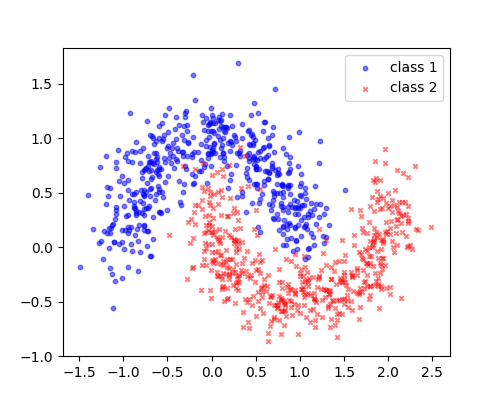

In [4]:
from sklearn.datasets import make_blobs, make_moons

N = 1000  
X, Y = make_moons(n_samples=N, noise=0.2)
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='b', marker='o', 
           s=10, alpha=0.5, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='r', marker='x', 
           s=10, alpha=0.5, label='class 2')
plt.legend()

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))


# Árbol de decisión

- Secuencia de operadores relacionales sobre los atributos en forma de árbol
- Los nodos "hoja" están asociados a una etiqueta (clasificación)
- Los nodos intermedios separan los datos (*splits*)
- Las separaciones se seleccionan usando la ganancia de información (*entropy*) o el índice de gini 

En *scikit learn* usamos el módulo [`tree`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) que tiene árboles para clasificación y regresión

    sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None,
                                        min_samples_split=2, min_samples_leaf=1, 
                                        in_weight_fraction_leaf=0.0, max_features=None, 
                                        random_state=None, max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, min_impurity_split=None, 
                                        class_weight=None, presort=False)

max_depth = determina el tamaño o profuyndidad del árbol "\n"
class_weight = nos permitesaber los parametros de resoltado final en cuanto al peso del árbol

Estudie como cambia el clasificador usando distintas profundidades máximas: parámetro `max_depth`

<IPython.core.display.Javascript object>


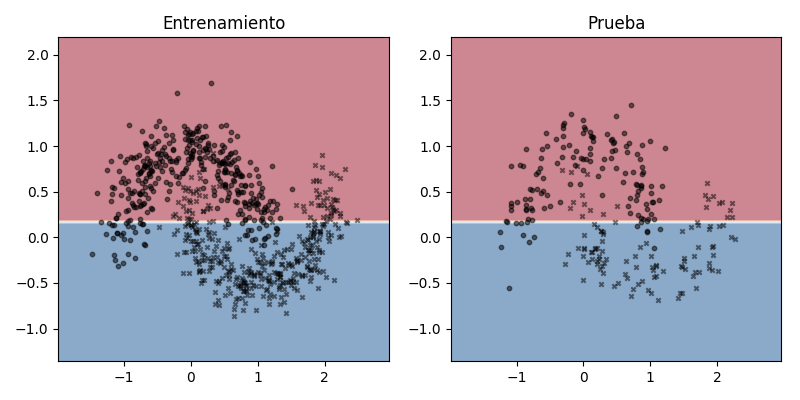

interactive(children=(IntSlider(value=1, continuous_update=False, description='max_depth', layout=Layout(heigh…

In [5]:
from sklearn import tree

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

def update_plot(max_depth):
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=max_depth)
    model.fit(X_train, Y_train)
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    for ax_ in ax:
        ax_.cla()
        ax_.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
    ax[0].set_title('Entrenamiento'); ax[1].set_title('Prueba')
    ax[0].scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], color='k', s=10, marker='o', alpha=0.5)
    ax[0].scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='k', s=10, marker='x', alpha=0.5)
    ax[1].scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='k', s=10, marker='o', alpha=0.5)
    ax[1].scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='k', s=10, marker='x', alpha=0.5)


widgets.interact(update_plot, max_depth=IntSlider_nice(min=1, max=51));

- La profundidad nos da complejidad
- Mucha profundidad provoca sobreajuste


> Usamos estrategias de validación para seleccionar la "mejor" profundidad

Por ejemplo 5-fold(Particiones) cross-validation

Se recomienda cuando los set de entrenamientos son pequeños, en caso contrario se ocupa a nivel global.

<a href="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation"><img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600"></a>


In [7]:
from sklearn.model_selection import KFold

# Crear kfold generator
fold_generator = KFold(n_splits=5) #permite decir si las particiones son contiguas al momento de dividir el conjunto de entrenamiento con comando "shufle"
# para cada profundidad
for max_depth in [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]: 
    #estos valores del max_depth serán validados deppendiendo de los resultados que entregue, cuales pueden
    #aumentar o bajos la cantidad de valores a evaluar la profundidad del árbol
    
    # crear un modelo
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=max_depth)
    # crear 5 splits
    score = np.zeros(shape=(5, ))
    for fold_index, (train_index, valid_index) in enumerate(fold_generator.split(X_train)):
        # entrenar en 4 folds
        model.fit(X_train[train_index], Y_train[train_index])
        # validar en 1 fold
        score[fold_index] = model.score(X_train[valid_index], Y_train[valid_index])
    # mostrar promedio y desviación estándar de la loss
    print("profundidad %d:\tloss validación: %f +/- %f" % (max_depth, np.mean(score), np.std(score)))

profundidad 1:	loss validación: 0.814667 +/- 0.010667
profundidad 2:	loss validación: 0.913333 +/- 0.018379
profundidad 3:	loss validación: 0.913333 +/- 0.018379
profundidad 4:	loss validación: 0.913333 +/- 0.018379
profundidad 5:	loss validación: 0.968000 +/- 0.007775
profundidad 6:	loss validación: 0.968000 +/- 0.004989
profundidad 8:	loss validación: 0.961333 +/- 0.012927
profundidad 10:	loss validación: 0.964000 +/- 0.009043
profundidad 15:	loss validación: 0.961333 +/- 0.006532
profundidad 20:	loss validación: 0.965333 +/- 0.007775


Podemos automatizar este procedimiento a más parámetros usando [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

Digamos que queremos encontrar el mejor criterio y la mejor profundidad:

In [8]:
from sklearn.model_selection import GridSearchCV

params = {'criterion':('entropy', 'gini'), 'max_depth':[1, 2, 3, 4, 5, 6, 8, 10, 15, 20]}
model = tree.DecisionTreeClassifier(splitter='best')
dts = GridSearchCV(model, params, cv=5)
dts.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ('entropy', 'gini'), 'max_depth': [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

El mejor árbol es:

In [9]:
model = dts.best_estimator_
print(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


<IPython.core.display.Javascript object>


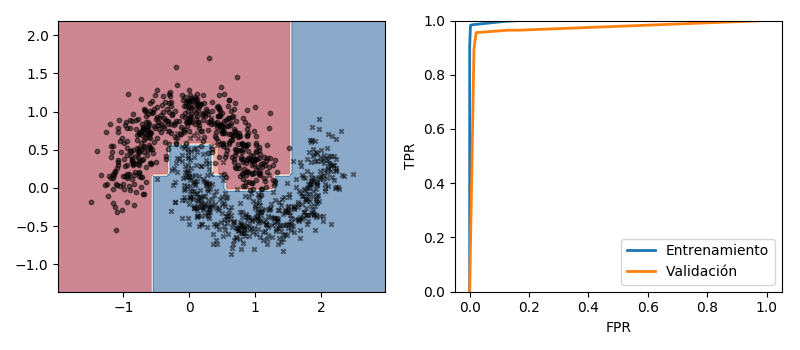

Entrenamiento: 0.989333
Validación: 0.968000


In [10]:
from sklearn.metrics import roc_curve
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)

print("Entrenamiento: %f" % (model.score(X_train, Y_train)))
print("Validación: %f" % (model.score(X_test, Y_test)))

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Validación', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);


# Gradient Boosting  

- Generaliza el concepto de boosting a cualquier función de costo derivable
- Cada clasificador en la cadena se entrena con los residuos del clasificador anterior

En scikit-learn en el módulo [`ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)(entre otros) se encuentra Gradient Boosting para clasificar y hacer regresión

    sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, 
                                                n_estimators=100, subsample=1.0, max_depth=3, ...)
                                                
Esta implementación usa árboles como clasificador débil

Explicación de los parámetros (algunos):
- n_estimators: Número de árboles
- max_depth: Profundidad de los árboles
- subsample: Se usa para que cada árbol use una submuestra del dataset
- learning_rate: Se usa para disminuir la contribución de cada árbol sucesivo (p*)
- max_features: Número de atributos a considerar en cada split (reduce la varianza)


Encontremos el mejor ensamble usando 5-fold cross validation

In [11]:
from sklearn import ensemble

params = {'loss':('deviance', 'exponential'), 
          'max_depth':[1, 5, 10, 20],
          'n_estimators': [1, 10, 20, 50, 100]}
model = ensemble.GradientBoostingClassifier(subsample=0.5, learning_rate=0.1, max_features=None)
gbs = GridSearchCV(model, params, cv=5)
gbs.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ('deviance', 'exponential'), 'max_depth': [1, 5, 10, 20], 'n_estimators': [1, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
means = gbs.cv_results_['mean_test_score'][gbs.cv_results_['param_loss']== 'deviance']
stds = gbs.cv_results_['std_test_score'][gbs.cv_results_['param_loss']== 'deviance']
for mean, std, params in zip(means, stds, gbs.cv_results_['params']):
    print("score: %0.3f (+/-%0.03f) con %r"
          % (mean, std * 2, params))

score: 0.817 (+/-0.029) con {'loss': 'deviance', 'max_depth': 1, 'n_estimators': 1}
score: 0.832 (+/-0.027) con {'loss': 'deviance', 'max_depth': 1, 'n_estimators': 10}
score: 0.879 (+/-0.040) con {'loss': 'deviance', 'max_depth': 1, 'n_estimators': 20}
score: 0.912 (+/-0.037) con {'loss': 'deviance', 'max_depth': 1, 'n_estimators': 50}
score: 0.933 (+/-0.025) con {'loss': 'deviance', 'max_depth': 1, 'n_estimators': 100}
score: 0.944 (+/-0.032) con {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 1}
score: 0.965 (+/-0.024) con {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 10}
score: 0.968 (+/-0.023) con {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 20}
score: 0.972 (+/-0.015) con {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 50}
score: 0.969 (+/-0.027) con {'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
score: 0.944 (+/-0.044) con {'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1}
score: 0.968 (+/-0.021) con {'loss': 'deviance', 'max_depth': 10,

El mejor modelo es:

In [13]:
model = gbs.best_estimator_
print(model)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=20,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


Gradient Boosting funciona bien con árboles poco profundo

Clasificador débil con alto sesgo y baja varianza

<IPython.core.display.Javascript object>


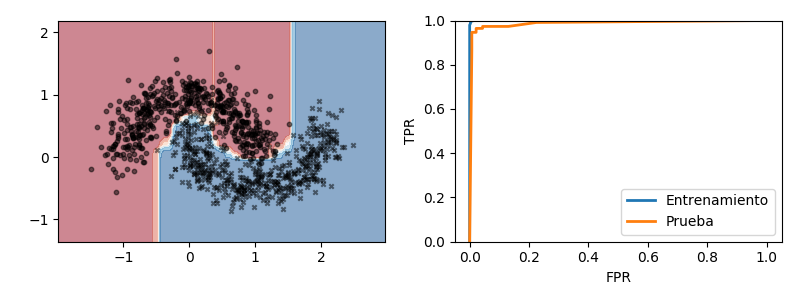

In [14]:
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Prueba', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);

Podemos comparar el rendimiento del mejor árbol con el mejor ensamble en el conjunto de Prueba

<IPython.core.display.Javascript object>


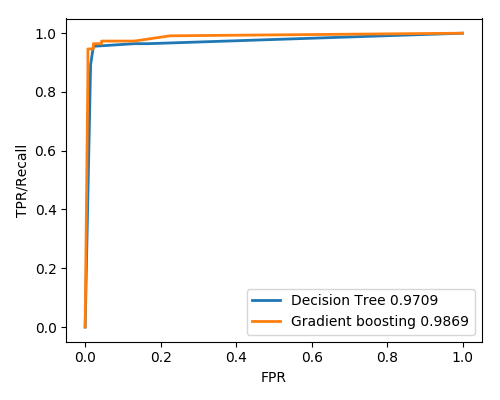

In [19]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(1, figsize=(5, 4), tight_layout=True)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR/Recall')

Y_pred = dts.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Decision Tree %0.4f" %auc(fpr, tpr), linewidth=2)

Y_pred = gbs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Gradient boosting %0.4f" %auc(fpr, tpr), linewidth=2)
plt.legend(loc=4);


# Random Forest

- Conjunto de árboles de decisión entrenados en paralelo usando bootstrap 
- Cada árbol se entrena con un **subconjunto aleatorio** de los datos (bagging)
- Cada árbol se entrena con un **subconjunto aleatorio** de los atributos (random forest)

Nuevamente en el módulo [`ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) podemos encontrar random forest para clasificar y hacer regresión

    sklearn.ensemble.RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None,
                                            max_features=’auto’, bootstrap=True, oob_score=False,
                                            n_jobs=None, class_weight=None, ...)
                                                

Explicación de los parámetros (algunos):
- n_estimators: Número de árboles
- max_depth: Profundidad de los árboles
- max_features: Número de atributos a considerar en cada split
- criterion: Para decidir como se escogen los splits
- bootstrap: Muestreo con reemplazo (desactiva bagging)
- class_weight: Usar o no una mayor ponderación para las clases menos representadas
- n_jobs: número de cores para entrenar




In [20]:
params = {'criterion':('entropy', 'gini'),
          'max_depth':[1, 5, 10, 20],
          'n_estimators': [1, 10, 20, 50, 100]}
model = ensemble.RandomForestClassifier(max_features=None, n_jobs=-1)
rfs = GridSearchCV(model, params, cv=5)
rfs.fit(X_train, Y_train)
display(rfs.best_estimator_)
display(rfs.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9746666666666667

El mejor Random Forest es:

In [21]:
model = rfs.best_estimator_
print(model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


A diferencia de GB, Random Forest prefiere árboles más profundos

Clasificadores débiles con bajo sesgo y alta varianza

<IPython.core.display.Javascript object>


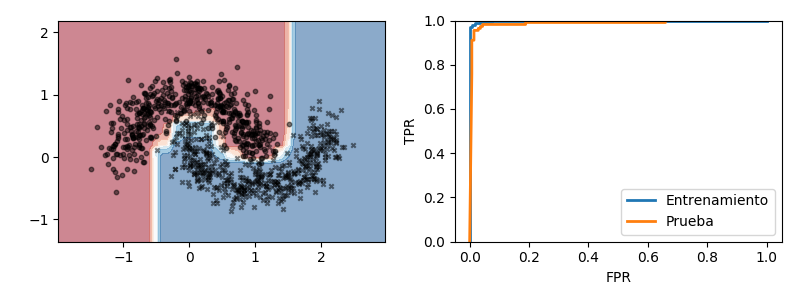

In [22]:
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Prueba', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);

Podemos comparar el rendimiento del mejor árbol con los mejores ensambles Prueba

<IPython.core.display.Javascript object>


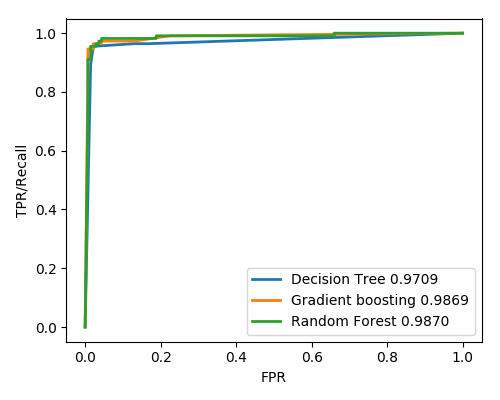

In [23]:
fig, ax = plt.subplots(1, figsize=(5, 4), tight_layout=True)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR/Recall')

Y_pred = dts.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Decision Tree %0.4f" %auc(fpr, tpr), linewidth=2)

Y_pred = gbs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Gradient boosting %0.4f" %auc(fpr, tpr), linewidth=2)

Y_pred = rfs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Random Forest %0.4f" %auc(fpr, tpr), linewidth=2)
plt.legend(loc=4);

# Más sobre ensambles

Dos algoritmos de Gradient Boosting para árboles de decisión (GBDT) extremadamente competitivos:
- [XGBoost](http://dmlc.cs.washington.edu/xgboost.html)
- [LightGBM](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree) e [implementación oficial](https://lightgbm.readthedocs.io/en/latest/index.html)

Ambos implementan estrategias para mejorar la eficiencia y realizar cálculos paralelos/distribuidos e incluso usando GPU

Estado del arte en clasificación de datos estructurados (tablas)

[Randomer Forest?](https://arxiv.org/abs/1506.03410v3)